# Transformations Notebook

This *notebook* contains illustrative code representing all the transformations performed by our solution, starting from the Digital Elevation Model and the remaining data (school locations, populations by geographic zones, etc...).

In this notebook, we will consider a small patch of land in Bengladesh, whose DEM is provided in the deposit.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import rasterio as rio

from osgeo import gdal
from os.path import join

INPUT_FOLDER = "D:/Donnees/Others/geographic/bangladesh"
OUTPUT_FOLDER = join(INPUT_FOLDER, "output")
FILEPATH = join(INPUT_FOLDER, "elevation_medium.tif")

We provide below the DEM of the considered land patch.

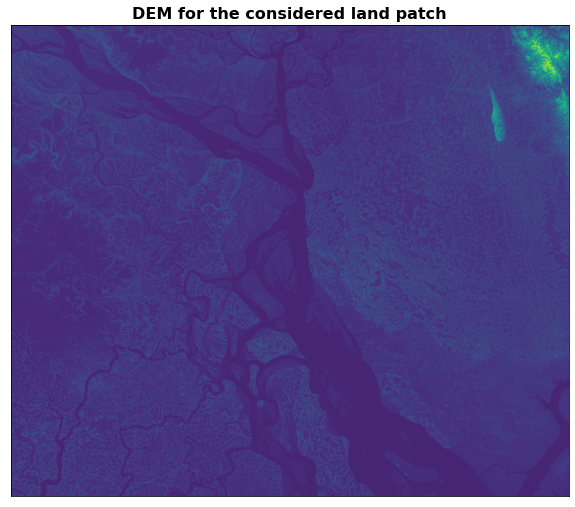

In [2]:
# turn TIF image into data array
dem = gdal.Open(FILEPATH).ReadAsArray()

fig, ax = plt.subplots(figsize=(10, 10))
plt.imshow(dem)
ax.set_title("DEM for the considered land patch", fontsize=16, fontweight="bold")
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

## Definition of flooded zones

Here, we implement the method that takes the Digital Elevation Model in input as well as sea elevation value (expressed in meter) and that returns the corresponding flooded zones.

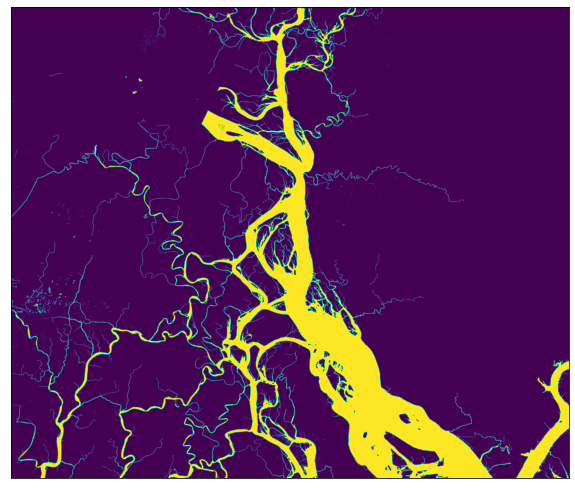

In [3]:
from matplotlib.image import AxesImage

elevation = 0.5

# 1st method : every altitude below elevation is flooded
mask = dem <= elevation

fig, ax = plt.subplots(figsize=(10, 10))
_ = plt.imshow(mask)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

In [4]:
def get_flooded_zones(dem, elevation):
    return dem <= mask

## Calculation of flooded schools

In this section, we will compute the list of flooded schools from the flooded zones computed in the previous section and the coordinates of the considered schools.

We start by importing the XY coordinates, in the WGS84 (EPSG:4326) referential, of all the considered schools.

In [13]:
schools = pd.read_csv(join(INPUT_FOLDER, "schools.csv"), header=0, sep=";", decimal=".")

schools = (
    schools
    .where((schools != "#VALEUR!").all(axis=1))
    .dropna()
    .rename(columns={"SCH_NAME": "school"})
    .astype({"x": float, "y": float})
)

schools.info()
schools.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16343 entries, 1 to 78045
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   school  16343 non-null  object 
 1   x       16343 non-null  float64
 2   y       16343 non-null  float64
dtypes: float64(2), object(1)
memory usage: 510.7+ KB


,school,x,y
1,SAHEBER HAT,90.158291,22.919375
2,POSHCHIM MOLLA PARA,90.158166,22.934544
3,Ahichirmat,90.149452,22.940150
5,ASHOKE SEN,90.161918,22.948621
6,SUJAN KATHI MAZID BARI,90.166171,22.959404


We implement a method that uses the DEM to check which school is in a flooded zone.

In [14]:
def get_flooded_schools(filepath, schools, elevation):
    with rio.open(filepath) as dataset:
        dem = dataset.read(1)
        no_data_flag = dataset.nodata
        
        # define flooded schools
        flooded = []
        for row in schools.index:
            longitude, latitude = schools.loc[row, "x"], schools.loc[row, "y"]
            px, py = dataset.index(longitude, latitude)
            if px >= 0 and py >= 0 and px < dem.shape[0] and py < dem.shape[1]:
                if (dem[px, py] != no_data_flag) and (dem[px, py] <= elevation):
                    flooded.append(row)
        
        return schools.loc[flooded, :]

Finally, we provide below some code that computes the table containing the flooded schools per year for every elevation level.

In [15]:
current_year = 2020
current_elevation = 0.0
target_year = 2030
target_elevation = 1.5

elevations = pd.Series(
    name="elevation",
    index=pd.Index(name="year", data=np.arange(current_year, target_year + 1)),
    data=np.linspace(current_elevation, target_elevation, target_year - current_year + 1)
)

temporal = pd.DataFrame()
for year, elevation in elevations.items():
    print(f"  . computing for year {year}")
    flooded_this_year = get_flooded_schools(filepath=FILEPATH, schools=schools, elevation=elevation)
    flooded_this_year["year"] = year
    flooded_this_year["elevation"] = elevation
    temporal = pd.concat((temporal, flooded_this_year), axis=0)
temporal = temporal.groupby("school").agg({"x": "first", "y": "first", "year": "min", "elevation": "min"})

temporal.info()
temporal.head()

  . computing for year 2020
  . computing for year 2021
  . computing for year 2022
  . computing for year 2023
  . computing for year 2024
  . computing for year 2025
  . computing for year 2026
  . computing for year 2027
  . computing for year 2028
  . computing for year 2029
  . computing for year 2030
<class 'pandas.core.frame.DataFrame'>
Index: 122 entries, 41 CHHURIR CHAR BOARD GOVERNMENT PRIMARY SCHOOL to W. BRAHAMMAN KATI
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   x          122 non-null    float64
 1   y          122 non-null    float64
 2   year       122 non-null    int64  
 3   elevation  122 non-null    float64
dtypes: float64(3), int64(1)
memory usage: 4.8+ KB


,x,y,year,elevation
school,,,,
41 CHHURIR CHAR BOARD GOVERNMENT PRIMARY SCHOOL,90.557245,23.270666,2020,0.0
44-NO TARABUNIA MAJHI BARI GOVERNMENT PRIMARY SCHOOL,90.546342,23.202455,2020,0.0
ALIMABAD,90.333981,22.991735,2020,0.0
ASHIGHAR,90.576116,22.877638,2020,0.0
BALUCHAR,90.727779,23.602758,2020,0.0


We export the desired data in the output folder.

In [16]:
(
    temporal
    .reset_index()
    [["year", "school", "x", "y", "elevation"]]
    .to_csv(join(OUTPUT_FOLDER, "school_flood_by_year.csv"), sep=",", header=True, index=False)
)